In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importing data

## Target

In [115]:
LOCAL_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/daily/energy_generation_data/df_deutschland.csv'

def get_target_data(path=LOCAL_PATH, target='wind', hourly=False):
    if hourly:
        path = path.replace('daily/','hourly/')
    df = pd.read_csv(path, index_col='Date')
    df.index = pd.to_datetime(df.index)
    if hourly:
        df = df.resample('h').sum()    
    else:
        df = df.resample('d').sum()
    if target == 'wind':
        return df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
    if target == 'solar':
        return df['Photovoltaics[MWh]']

target_df = get_target_data(target='wind', hourly=True)


## Features

In [116]:
def get_best_station_ids(features_df, target_df, corr=0.6):
    features_df['target'] = target_df
    corr_df = features_df.corr()
    best_stations = list(corr_df['target'][corr_df['target']>=corr].index)[:-1]
    init_length = len(features_df.columns)
    final_length = len(best_stations)
    print(f'Droped {init_length - final_length} stations!')
    
    return best_stations

In [117]:
FEATURES_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/daily/features'

hourly_files = {'wind_speed': 'wind_hourly_clean.csv',
                 'air_pressure': 'hourly_airp_df.csv',
                 'humidity': 'hourly_humidity_df.csv',
                 'temperature': 'hourly_temperature_df.csv',
                 'clouds': 'hourly_cloud_df.csv'}

daily_files = {'wind_speed': 'winddailyofeverystation.csv',
               'air_pressure': 'daily_airp_df.csv',
               'humidity': None,
               'temperature': None,
               'clouds': None}


def get_features_data(path=FEATURES_PATH, features=['wind_speed'], optimized=True, grouped=True, hourly=False):
    df = pd.DataFrame(index=target_df.index)
    
    for feature in features:
        if hourly and hourly_files[feature]:
            path = FEATURES_PATH.replace('/daily/features',f'/hourly/features/{hourly_files[feature]}')
        elif daily_files[feature]:
            path = f'{path}/winddailyofeverystation.csv'
        else:
            continue
        feat_df = pd.read_csv(path, index_col='Date')
        feat_df.index = pd.to_datetime(feat_df.index)
        if optimized:
            best_stations = get_best_station_ids(feat_df, target_df)
            feat_df = feat_df[best_stations]
        if grouped:
            feat_df = feat_df.mean(axis=1)
            df[feature] = feat_df
        else:
            feat_df.rename(columns = {column: f'{column}_{feature[0]}' for column in feat_df.columns}, inplace=True)
            df = df.join(feat_df)

    return df

features_df = get_features_data(features =['wind_speed', 'air_pressure', 'clouds', 'humidity', 'temperature'], optimized=False, grouped=True, hourly=True)


In [118]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

feature_pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

feat_scaled = feature_pipe.fit_transform(features_df)
feat_scaled_df = pd.DataFrame(feat_scaled, columns=features_df.columns, index=features_df.index)

##  Forecasted

In [6]:
FORCASTED_PATH = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/daily/forecasted_generation_data/df_deutschland_forecasted.csv'

def get_forcasted_data(path=FORCASTED_PATH, target='wind', hourly=False):
    if hourly:
        path = path.replace('/daily/', '/hourly/')
    df = pd.read_csv(path, index_col='Date')
    df.index = pd.to_datetime(df.index)
    if hourly:
        df = df.resample('h').sum()
    else:
        df = df.resample('d').sum()
    if target == 'wind':
        return df[['Wind offshore[MWh]','Wind onshore[MWh]']].sum(axis=1)
    if target == 'solar':
        return df['Photovoltaics[MWh]']

forcasted_df = get_forcasted_data(target='wind', hourly=False)
    

In [ ]:
#forecasted_df.loc[dt.date(2018,1,1):dt.date(2018,3,1)]

# Statistical exploration

## Train Test Split

In [131]:
target_df.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2021-04-30 14:00:00', '2021-04-30 15:00:00',
               '2021-04-30 16:00:00', '2021-04-30 17:00:00',
               '2021-04-30 18:00:00', '2021-04-30 19:00:00',
               '2021-04-30 20:00:00', '2021-04-30 21:00:00',
               '2021-04-30 22:00:00', '2021-04-30 23:00:00'],
              dtype='datetime64[ns]', name='Date', length=55488, freq='H')

In [136]:
def get_X_y(target_df, features_df, init_date=dt.datetime(2015,1,1), end_date=dt.datetime(2016,1,1), scaled=False):
    '''return the the target and features data between the init_date and end_date time window'''
    if scaled:
        target_df = pd.Series(np.log(target_df.values), index=target_df.index)
    X = features_df.loc[init_date:end_date,:]
    y = target_df.loc[init_date:end_date]
    return X, y

X, y = get_X_y(target_df, features_df, init_date=dt.date(2020,6,1), end_date=dt.date(2021,1,5), scaled=True)

<ipython-input-136-525d6fe1ef14>:4: RuntimeWarning: divide by zero encountered in log
  target_df = pd.Series(np.log(target_df.values), index=target_df.index)


In [137]:
def train_test_split(X, y, test_hours=24*2):
    index = len(X) - test_hours
    X_train = X.iloc[:index]
    X_test = X.iloc[index:]
    y_train = y.iloc[:index]
    y_test = y.iloc[index:]
    
    return X_train, X_test, y_train, y_test

days = 4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_hours=24*days)

## Stationarity

### Visually

<AxesSubplot:>

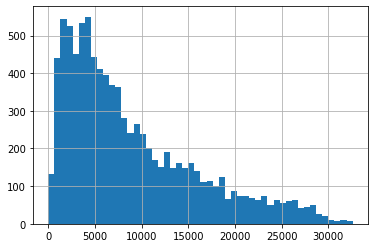

In [9]:
y.hist(bins=50)

<AxesSubplot:xlabel='Date'>

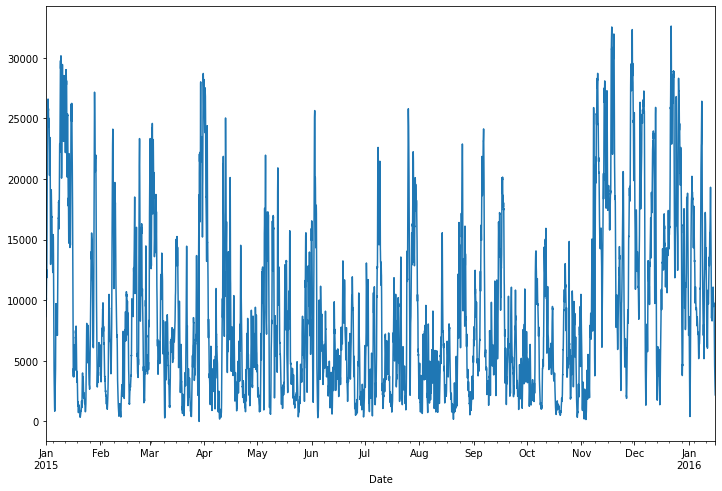

In [10]:
plt.subplots(figsize=(12,8))
y.plot()

###  Calculations (mean, variance and autocorrelation)

In [143]:
def plot_autocorrelation(y, d=0, D=0, m=0):
    y = pd.Series(y)
    if D > 0:
        for i in range(D):
            y = y.diff(m).dropna()
    if d > 0:
        for i in range(d):
            y = y.diff(1).dropna()
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,2,3)
    ax3 = fig.add_subplot(2,2,4)
    ax1.plot(y)
    plot_acf(y, lags = 50, ax=ax2);
    plot_pacf(y, lags=50, ax=ax3, color='r');
    plt.show()

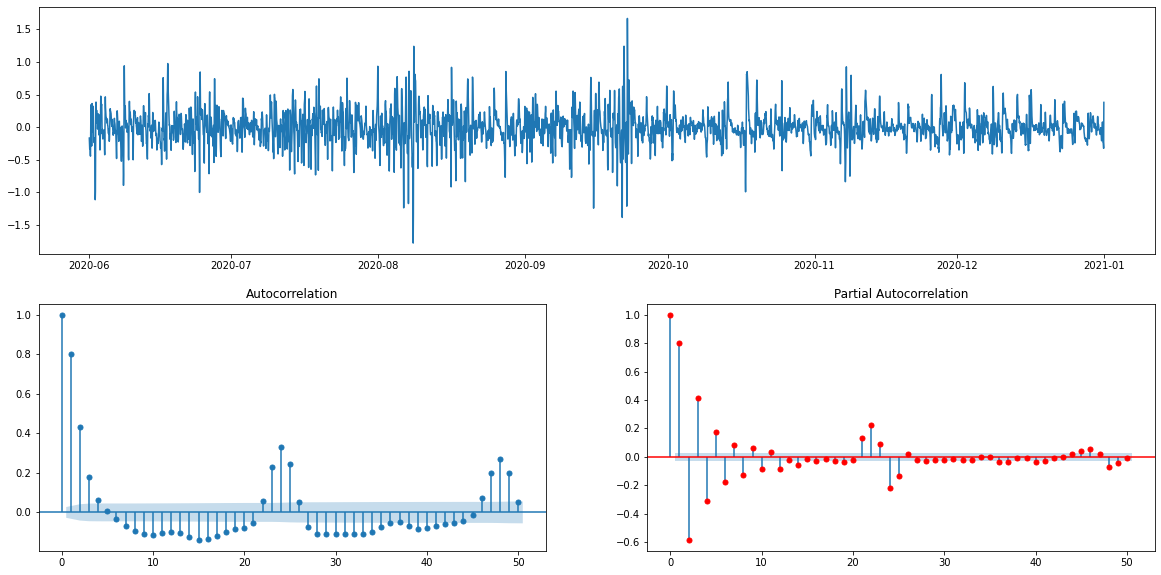

In [144]:
plot_autocorrelation(y_train, d=0, D=1, m=2)

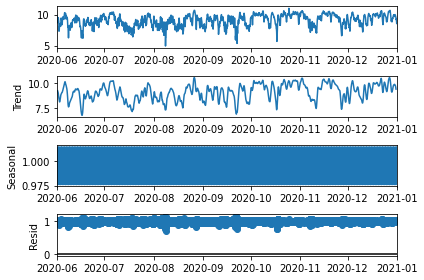

In [145]:
result_add = seasonal_decompose(y_train, model='multiplicative')
result_add.plot();

<AxesSubplot:xlabel='Date'>

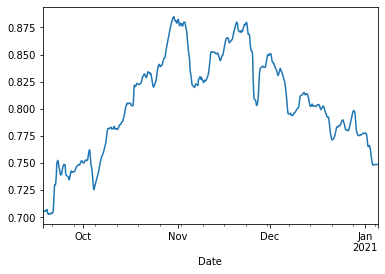

In [146]:
y.rolling(window=int(len(y)/2)).var().dropna().plot()

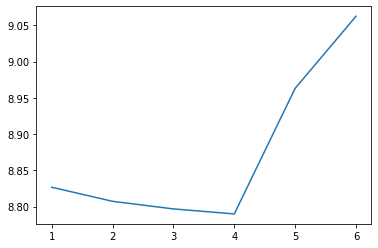

In [147]:
means = []

for year in range(1, 8):
    means.append(y[f'2020-{year}':f'2020-{year+4}'].mean())

plt.plot(means)

In [154]:
# p-value (should be less than 0.05 to be sattionary)
adfuller(y_train)[1]

4.7329962368288775e-11

0.008671698273998753

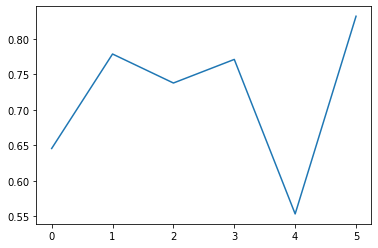

In [156]:
var = []

for month in range(6, 12):
    var.append(y[f'2020-{month}'].var())

plt.plot(var)
np.array(var).var()

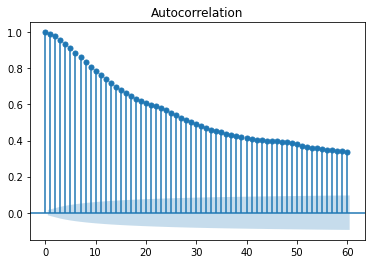

In [301]:
plot_acf(y.dropna(), lags=60);

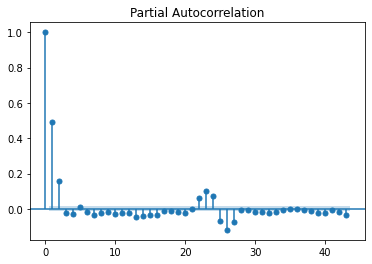

In [302]:
plot_pacf(y.diff().dropna());

In [157]:
adfuller(y.diff(24).dropna())

(-13.015266629267176,
 2.5187179923880642e-24,
 32,
 5176,
 {'1%': -3.4316140158442305,
  '5%': -2.8620985625001385,
  '10%': -2.56706732277764},
 -10244.134358646596)

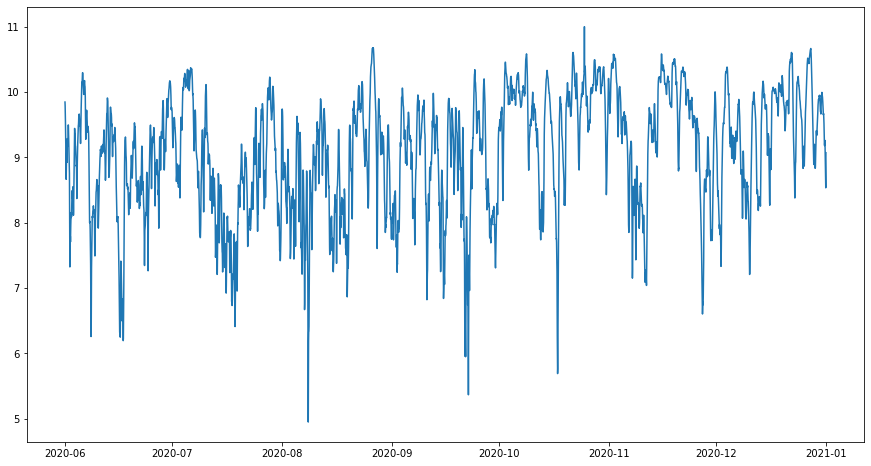

In [158]:
plt.subplots(figsize=(15,8))
plt.plot(y_train)

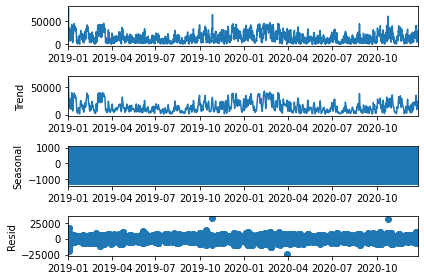

In [189]:
result_mul = seasonal_decompose(y_train, model='addictive')
result_mul.plot();

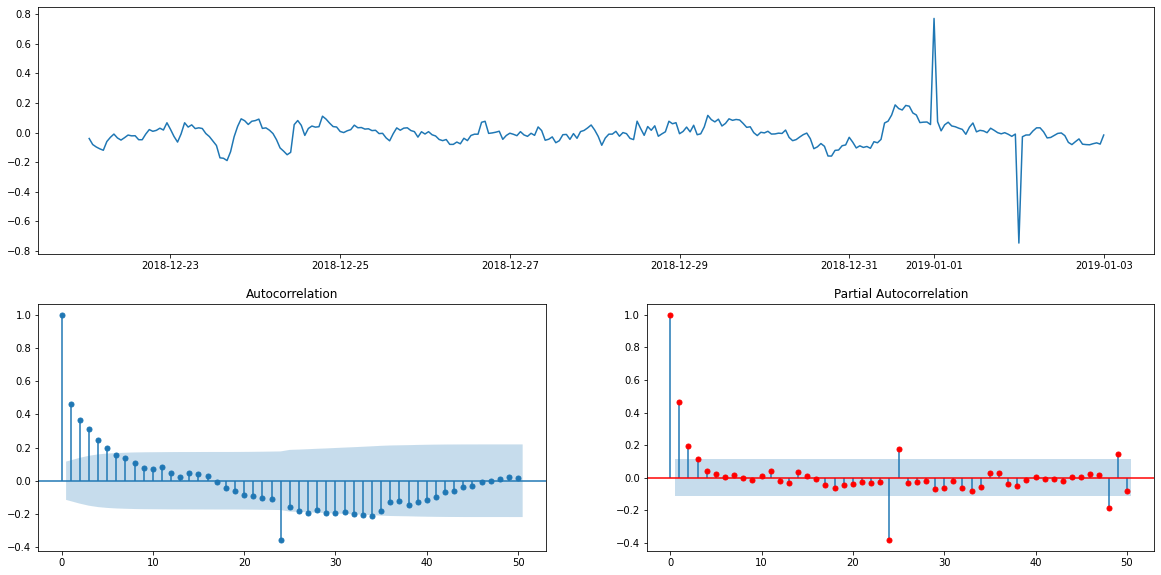

In [68]:
plot_autocorrelation(y['2018-12-22':], d=1, D=0, m=24)

In [159]:
import pmdarima as pm

smodel = pm.auto_arima(y_train, m=24, X=X_train.to_numpy(),
                       start_p=0, max_p=2,
                       start_d=0, max_d=1,
                       start_q=0, max_q=2,
                       start_P=0, max_P=2,
                       start_D=0, max_D=3,
                       start_Q=0, max_Q=2,
                       seasonal=True, trace=True, njobs=-1, error_action='ignore',  
                       stepwise=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=8107.497, Time=1.91 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-8353.831, Time=30.67 sec


/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1897: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=7751.707, Time=16.46 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=8158.369, Time=5.12 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-7567.524, Time=5.16 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=-8547.874, Time=167.87 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=-8533.852, Time=198.50 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=-8436.240, Time=66.74 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=7526.810, Time=48.68 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=-11145.660, Time=189.98 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=-11019.529, Time=97.08 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=-11111.627, Time=217.60 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=-10946.412, Time=94.64 sec
 ARIMA(2,0,1)(2,0,0)[24] intercept   : AIC=-11326.413, Time=203.04 sec
 ARIMA(2,0,1)(1,0,0)[24] intercept   : AIC=-11248.415, Time=95.64 sec
 ARIMA(2,0,1)(2,0,1)[24] intercept   : AIC=-11338.401, Time=247.81 sec
 ARIMA(2,0,1)(1,0,1)[24] i

In [160]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 5137
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood                5706.561
Date:                            Tue, 15 Jun 2021   AIC                         -11385.123
Time:                                    20:53:40   BIC                         -11293.504
Sample:                                         0   HQIC                        -11353.056
                                           - 5137                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2168      0.014     15.851      0.000       0.190       0.244
x2             0.0080      0.000     27.492      0.000       0.007       0.009
x3             0.0166      0.005      3.535      0.000       0.007       0.026
x4             0.0073      0.002      3.267      0.001       0.003       0.012
x5            -0.0111      0.008     -1.434      0.152      -0.026       0.004
ar.L1          1.1488      0.029     39.374      0.000       1.092       1.206
ar.L2         -0.2134      0.029     -7.430      0.000      -0.270      -0.157
ma.L1          0.6394      0.027     23.523      0.000       0.586       0.693
ma.L2          0.2385      0.021     11.621      0.000       0.198       0.279
ar.S.L24       0.2515      0.403      0.624      0.532      -0.538       1.041
ar.S.L48       0.1796      0.255      0.704      0.481      -0.320       0.679
ma.S.L24       0.0339      0.403      0.084      0.933      -0.756       0.824
ma.S.L48      -0.0506      0.145     -0.350      0.726      -0.334       0.233
sigma2         0.0063   5.18e-05    121.958      0.000       0.006       0.006
===================================================================================
Ljung-Box (L1) (Q):                   6.20   Jarque-Bera (JB):             90024.07
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [161]:
central, confint = smodel.predict(n_periods=len(y_test), X=X_test, return_conf_int=True)
index_y_test = y_test.index #pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
central = pd.Series(central, index=index_y_test)
lower = pd.Series(confint[:, 0], index=index_y_test)
upper = pd.Series(confint[:, 1], index=index_y_test)

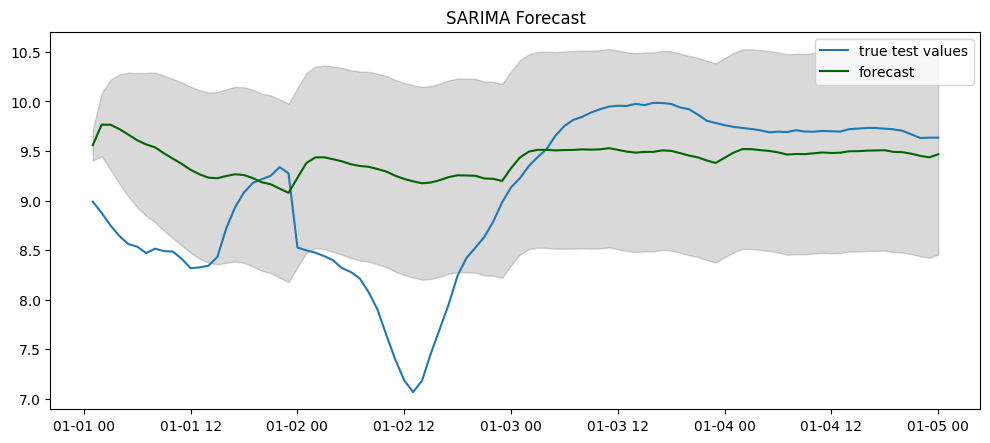

In [162]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(y_train, label = "train values")
plt.plot(y_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [168]:
mean_absolute_percentage_error(y_test, central)

7.195811338454076

# Models

## SARIMAX

In [169]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [170]:
sarimax = SARIMAX(endog=y_train, exog=X_train, order=(2,1,0), seasonal_order=(2,0,0,24)).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [190]:
y_pred = sarimax.predict(len(X_test), exog=X_test, alpha=0.05)


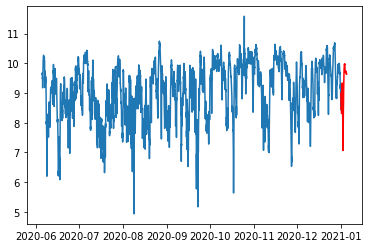

In [185]:
plt.plot(y_pred)
plt.plot(y_test, color='r')
#plt.plot(central, color='g')

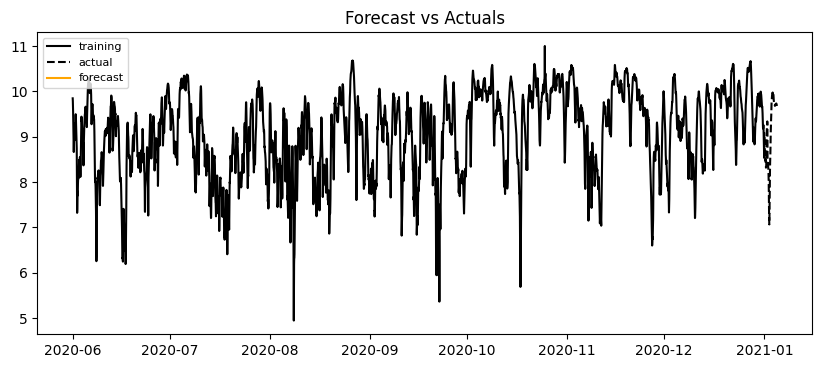

In [186]:
plot_forecast(y_pred, y_train, y_test)

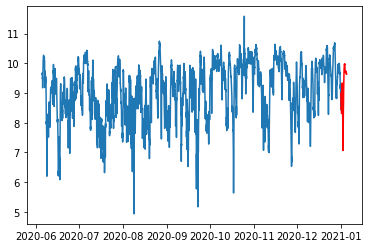

In [189]:
plt.plot(y_pred)
plt.plot(y_test, color='r')

In [180]:
y_pred.shape

(5041,)

In [179]:
mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred))

ValueError: operands could not be broadcast together with shapes (96,) (5041,) 

## RandomForest

In [448]:
df = pd.DataFrame(target_df, columns=['production']).copy()
df["x_1"] = df["production"].shift(1)
df["x_2"] = df["production"].shift(2)
df["x_3"] = df["production"].shift(3)
df["x_4"] = df["production"].shift(4)
df["x_5"] = df["production"].shift(5)
df["x_6"] = df["production"].shift(6)
df["x_7"] = df["production"].shift(7)
df["x_8"] = df["production"].shift(8)
df["x_9"] = df["production"].shift(9)
df["x_10"] = df["production"].shift(10)
df["x_11"] = df["production"].shift(11)
df["x_12"] = df["production"].shift(12)

In [449]:
# Extract the trend using a well chosen moving average
df['ma_24'] = df['x_2'].rolling(window=24).mean()
df['ma_12'] = df['x_2'].rolling(window=12).mean()
df['ma_3'] = df['x_2'].rolling(window=3).mean()
df['ma_2'] = df['x_2'].rolling(window=2).mean()

df["ewma_2"] = df["x_2"].ewm(halflife=2).mean()
df["ewma_3"] = df["x_2"].ewm(halflife=3).mean()
df["ewma_12"] = df["x_2"].ewm(halflife=12).mean()
df["ewma_24"] = df["x_2"].ewm(halflife=24).mean()

In [450]:
# Drop nan
df = df.dropna()

#train test split
X, y = get_X_y(df.production, df.drop('production', axis=1), init_date=dt.date(2020,10,1), end_date=dt.date(2021,1,3), scaled=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_hours=24)

In [451]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

In [65]:
# Keep track of test_indexes
test_indexes = np.arange(len(X_train), len(X))
test_indexes

array([2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243,
       2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254,
       2255, 2256])

In [66]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [462]:
def get_next_features(train_features, train_target):
    data = pd.DataFrame(np.append(train_target.reshape(-1,1),train_features, axis=1), columns=df.columns)
    t_feat = pd.Series(index=X.columns, dtype='float64')
    #print(data.index[-1])
    for _t in range(1,13):
        exec(f't_feat["x_{_t}"] = data.iloc[-{_t}]["production"]')
    for _t in [2, 3, 12, 24]:
        #print(data['x_2'].append(pd.Series(t_feat['x_1'])).rolling(window=_t).mean().iloc[-1])
        exec(f"t_feat['ma_{_t}'] = data['x_1'].append(pd.Series(t_feat['x_1'])).rolling(window={_t}).mean().iloc[-1]")
        exec(f"t_feat['ewma_{_t}'] = data['x_1'].append(pd.Series(t_feat['x_1'])).ewm(halflife={_t}).mean().iloc[-1]")
    return t_feat.values

def evaluate_performance_hourly_prediction(y_train, y_test, predictor, X):
    predictions = []
    train_target = y_train.values
    train_features = X.values
    i=0
    for _ in range(len(y_test)):
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_target)
        next_features = get_next_features(train_features, train_target)
        prediction = predictor.predict(next_features.reshape(1,-1))[0]
        #print(np.array([prediction]).shape)
        train_target = np.append(train_target, np.array([prediction]), axis=0)
        train_features = np.append(train_features, next_features.reshape(1,-1), axis=0)
        predictions.append(prediction)
        i+=1
    #print(i)
    mape = np.mean(np.abs(np.array(predictions) - np.array(y_test))/np.abs(np.array(y_test)))
    return y_test, predictions, mape

In [463]:
results = evaluate_performance_hourly_prediction(y_train=y_train, y_test=y_test,
                                                         predictor=random_forest, X=X_train)

In [452]:
results = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X.values)

In [464]:
# MAPE
results[2]

0.670809018654846

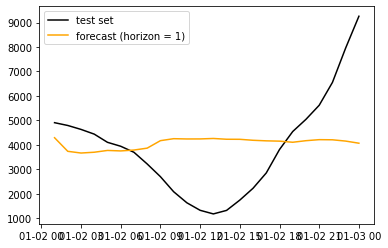

In [465]:
plt.plot(results[0], c='black', label='test set')
plt.plot(pd.Series(results[1], index=results[0].index), c='orange', label='forecast (horizon = 1)')
plt.legend()

In [466]:
importances = random_forest.feature_importances_
pd.DataFrame(zip(importances, list(X_train.columns))).sort_values(by=0, ascending=False)

,0,1
0,0.987438,x_1
1,0.002145,x_2
2,0.001143,x_3
15,0.001138,ma_2
3,0.001109,x_4
14,0.000872,ma_3
16,0.000679,ewma_2
12,0.000541,ma_24
11,0.000531,x_12
19,0.000528,ewma_24


# Evaluations

In [164]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## model_8

In [ ]:
y_pred = model_8.forecast(len(y_test), exog=X_test, alpha=0.05)

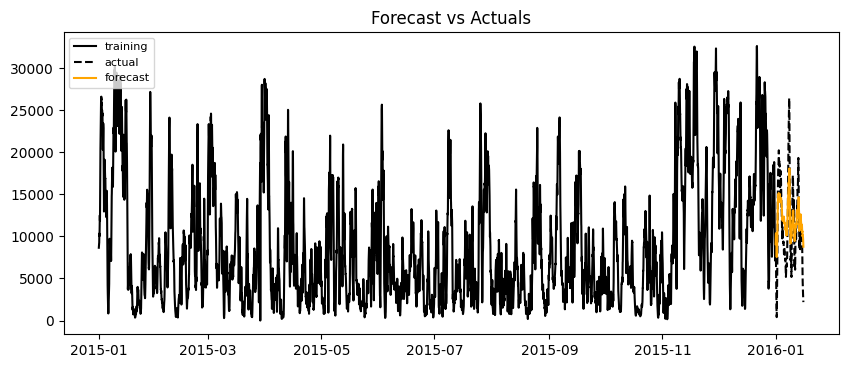

In [58]:
plot_forecast(y_pred, y_train, y_test)

In [45]:
model_8.mae

340.0432823356836

In [48]:
mae(y_test, y_pred)

3474.8045601605695

In [49]:
mse(y_test, y_pred)

17229826.977893803

In [50]:
mean_absolute_percentage_error(y_test, y_pred)

62.571837013493834

## model_10

In [71]:
y_pred = model_10.forecast(len(y_test), exog=X_test, alpha=0.05)

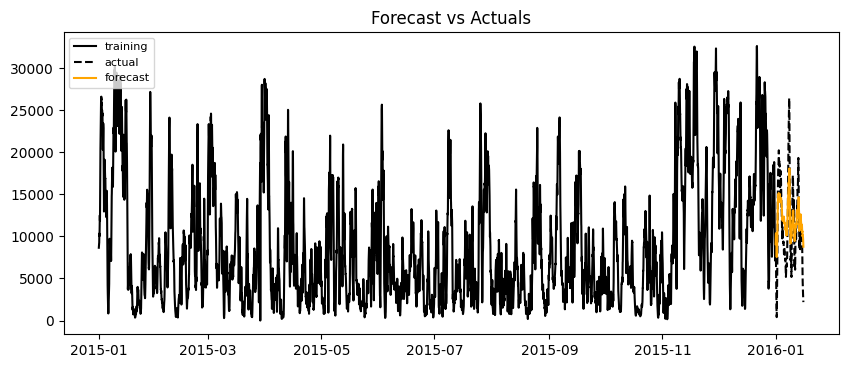

In [58]:
plot_forecast(y_pred, y_train, y_test)

In [72]:
mae(y_test, y_pred)

2827.8653712675423

In [73]:
mse(y_test, y_pred)

11652640.658651238

In [74]:
mean_absolute_percentage_error(y_test, y_pred)

50.545070786224656

## model_11

In [87]:
y_pred = model_11.forecast(len(y_test), exog=X_test, alpha=0.05)

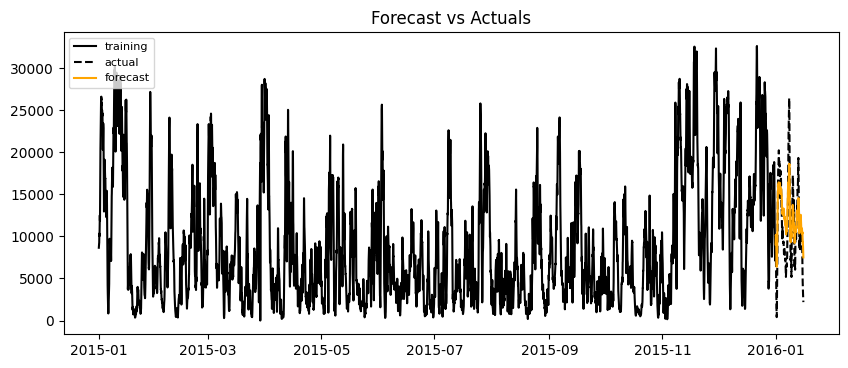

In [88]:
plot_forecast(y_pred, y_train, y_test)

In [89]:
mae(y_test, y_pred)

2741.0597859021373

In [90]:
mse(y_test, y_pred)

10602976.346378602

In [91]:
mean_absolute_percentage_error(y_test, y_pred)

47.22682448948714

## model_12

<AxesSubplot:xlabel='Date'>

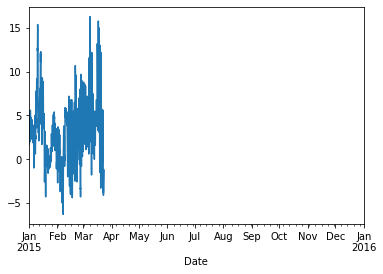

In [105]:
X_train['air_pressure'].plot()

In [104]:
X_train.isna().sum()

wind_speed         0
air_pressure    6808
dtype: int64

In [101]:
model_12 = SARIMAX(endog=y_train, exog=X_train, order=(1,1,2), seasonal_order=(2,0,0,24)).fit()

MissingDataError: exog contains inf or nans

In [57]:
y_pred = model_12.forecast(len(y_test), exog=X_test, alpha=0.05)

## baseline

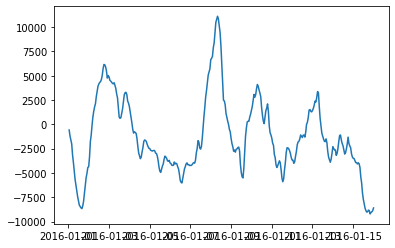

In [43]:
residuals = y_test - y_pred
plt.plot(residuals)

In [46]:
sarimax.mae

340.0432823356836

In [36]:
mae(y_test, forecast)

3474.8045601605695

In [37]:
sarimax.mse

370485.49749783427

In [38]:
mse(y_test, forecast)

17229826.977893803

In [39]:
mean_absolute_percentage_error(y_test, forecast)

62.571837013493834

In [34]:
# asbolute values MAPE
baseline = mean_absolute_percentage_error(y_test, forecast)
baseline

8.52754434601609

In [35]:
# log values MAPE
log_baseline = mean_absolute_percentage_error(np.log(y_test), np.log(forecast))
log_baseline

0.8707221647966732

In [67]:
# SMARD forcast MAPE
mean_absolute_percentage_error(y_test, forcasted_df.loc[dt.date(2016,1,1):dt.date(2016,3,31)])

NameError: name 'forcasted_df' is not defined

In [ ]:
# SMARD log forcast MAPE
THE_BAR = mean_absolute_percentage_error(y_test, np.log(mini_forecast))
THE_BAR